## Контекстно-независимое векторное представление слов 

1. Используйте тексты из предыдущего задания и обучите на них модель векторного представления слов (опционально можно приводить слова к нормальной форме и удалить стоп-слова). Можно использовать `gensim`.

2. Разделите коллекцию текстов на обучающее и тестовое множество. С помощью обученной модели векторного представления отобразите каждый документ в вектор, усреднив все вектора для слов документа. 

3. Используйте какой-либо алгоритм классификации (например `SVM`) для классификации текстов. Для обучения используйте тестовое множество, для анализа результатов - тестовое.

4. Простое усреднение векторов слов обычно не дает хорошего отображения документа в вектор. Придумайте альтернативный способ. Протестируйте его, повторно обучив алгоритм классификации на тех же данных. 


In [121]:
import pymorphy3
import numpy as np
from nltk.corpus import stopwords

1. Используйте тексты из предыдущего задания и обучите на них модель векторного представления слов (опционально можно приводить слова к нормальной форме и удалить стоп-слова). Можно использовать `gensim`.

In [122]:
import gzip
import re

from gensim.models import Word2Vec

from dataclasses import dataclass
from typing import Iterator, List

@dataclass
class Text:
    label: str
    title: str
    text: str

# Чтение файла данных
def read_texts(fn: str="data/news.txt.gz") -> Iterator[Text]:
    with gzip.open(fn, "rt", encoding="utf-8") as f:
        for line in f:
            yield Text(*line.strip().split("\t"))
                    

morph = pymorphy3.MorphAnalyzer()
ru_stopwords = set(stopwords.words("russian"))
# Разбиение текста на слова                 
def tokenize_text(text: str) -> List[str]:
    text = text.lower()
    words = re.findall(r'\b\w+\b', text.lower())
    words = [
        morph.parse(word)[0].normal_form for word in words if word not in ru_stopwords
    ]
    return words

In [6]:
print(", ".join(ru_stopwords))

два, вот, вдруг, был, нибудь, один, его, есть, тогда, всю, а, было, со, быть, или, лучше, эту, эти, разве, все, к, они, этом, ж, чем, даже, еще, были, уж, другой, ли, сам, только, этого, вам, больше, на, при, тоже, моя, совсем, может, ну, ведь, тем, под, кто, ней, куда, можно, три, за, меня, вы, иногда, чтоб, опять, впрочем, перед, никогда, надо, хоть, он, себе, нет, чтобы, от, свою, была, там, она, нельзя, что, уже, теперь, того, и, потом, ни, с, их, какая, конечно, зачем, им, о, без, чуть, между, во, всего, мне, у, мы, в, мой, хорошо, для, когда, много, же, более, будто, как, этой, потому, но, тут, ему, ее, да, ты, не, по, раз, нее, где, почти, если, над, так, будет, про, такой, всех, после, него, то, нас, ничего, ей, том, этот, тот, здесь, себя, чего, бы, сейчас, я, через, какой, об, до, наконец, из, тебя, них, ним, всегда, вас


In [7]:
sentences = [tokenize_text(text.text) for text in read_texts()]

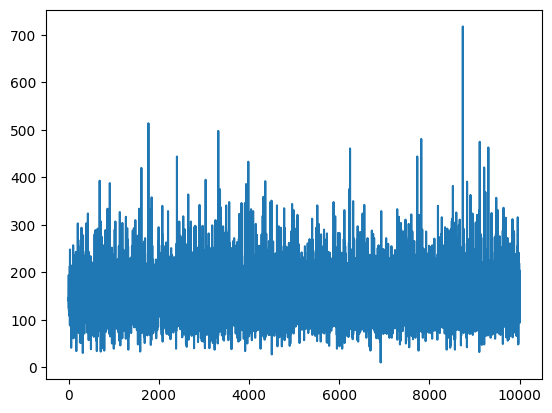

In [ ]:
import matplotlib.pyplot as plt

lens = [len(doc) for doc in sentences]

plt.plot(list(range(len(sentences))), lens)

In [8]:
# обучаем w2v
w2v = Word2Vec(sentences)

# сохраняем модель
w2v.wv.save_word2vec_format('w2v_vectors.bin')

In [9]:
# пример
w2v.wv.most_similar("париж")

[('лондон', 0.8699202537536621),
 ('франциско', 0.8602492213249207),
 ('красноярск', 0.8198821544647217),
 ('анджелесский', 0.8080084919929504),
 ('прилететь', 0.8079586625099182),
 ('екатеринбург', 0.8074092268943787),
 ('амстердам', 0.802464485168457),
 ('сан', 0.7966002225875854),
 ('торжественный', 0.7931874990463257),
 ('токио', 0.7927892208099365)]

In [10]:
print(w2v.wv.most_similar(positive=["россия", "париж"], negative=['франция'])[0])
print(w2v.wv.most_similar(positive=["ребёнок", "женщина"], negative=['мужчина'])[0])

('москва', 0.6037968397140503)
('родитель', 0.8632623553276062)


In [11]:
w2v.wv.most_similar("бег")

[('вольный', 0.9370482563972473),
 ('полутяжёлый', 0.9310805201530457),
 ('серебро', 0.9237045049667358),
 ('проплыть', 0.9073843359947205),
 ('кливленд', 0.9070919752120972),
 ('полулёгкий', 0.9007498621940613),
 ('завоёвывать', 0.9001500606536865),
 ('дарья', 0.8988481163978577),
 ('прыжок', 0.8982142210006714),
 ('метание', 0.8981910347938538)]

In [12]:
w2v.wv.most_similar("сентябрь")

[('апрель', 0.9849188327789307),
 ('февраль', 0.9821366667747498),
 ('ноябрь', 0.9812560677528381),
 ('октябрь', 0.9798616766929626),
 ('март', 0.9773834943771362),
 ('май', 0.9773556590080261),
 ('июль', 0.9764798283576965),
 ('август', 0.9761109948158264),
 ('июнь', 0.9727715849876404),
 ('декабрь', 0.9718945026397705)]

Прикольно :)

2. Разделите коллекцию текстов на обучающее и тестовое множество. С помощью обученной модели векторного представления отобразите каждый документ в вектор, усреднив все вектора для слов документа. 

In [54]:
from sklearn.model_selection import train_test_split

labels = [text.label for text in read_texts()]
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

def from_words_to_vec(documents):
    document_vectors = []
    for document in documents:
        vectors = [
            w2v.wv[word] for word in document if word in w2v.wv
        ]
        document_vectors.append(vectors)

    document_vectors_mean = [np.mean(vectors, axis=0) for vectors in document_vectors]
    return document_vectors_mean

X_train_durty = from_words_to_vec(X_train)
X_test_durty = from_words_to_vec(X_test)



3. Используйте какой-либо алгоритм классификации (например `SVM`) для классификации текстов. Для обучения используйте тестовое множество, для анализа результатов - тестовое.

In [55]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc= SVC()
svc.fit(X_train_durty, y_train)

y_pred = svc.predict(X_test_durty)



accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8015


In [62]:
def transform_text(text: str) -> list:
    normalized_text = tokenize_text(text)
    vector = [
        w2v.wv[word] for word in normalized_text if word in w2v.wv
    ]
    return [np.mean(vector, axis=0)]

In [63]:
set(labels)

{'business',
 'culture',
 'economics',
 'forces',
 'life',
 'media',
 'science',
 'sport',
 'style',
 'travel'}

In [64]:
svc.predict(transform_text("Футбольное Динамо забило гол и выиграло"))[0]

'life'

In [66]:
svc.predict(transform_text("Выборы президента РФ состоятся после 12 марта"))[0]

'sport'

In [67]:
svc.predict(transform_text("Овечкин забил долгожданный гол в пустые ворота"))[0]

'sport'

4. Простое усреднение векторов слов обычно не дает хорошего отображения документа в вектор. Придумайте альтернативный способ. Протестируйте его, повторно обучив алгоритм классификации на тех же данных. 

Кластеризуем слова в документах на k класстеров и выкинем самые встречаемые (неинформативные слова)

In [118]:
from sklearn.cluster import KMeans
from collections import Counter, OrderedDict


def cluster_and_average_vectors(list_of_words, k=5, num=1):
    words_count = Counter(list_of_words).most_common()

    words_count_vectors = [w2v.wv[word] for word, _ in words_count if word in w2v.wv]

    if len(words_count_vectors) <= k:
        return np.mean(words_count_vectors, axis=0)
    
    k_means = KMeans(n_clusters=k, n_init="auto", random_state=2)
    clusters = k_means.fit_predict(words_count_vectors)

    clusters_to_delete = list(OrderedDict.fromkeys(clusters))[:num]


    filtered_vectors = []
    for i, cluster in enumerate(clusters):
        if cluster not in clusters_to_delete:
            filtered_vectors.append(words_count_vectors[i])

    return np.mean(filtered_vectors, axis=0)



In [119]:
X_train_cleaned = [cluster_and_average_vectors(document, k=60, num=1) for document in X_train]
X_test_cleaned = [cluster_and_average_vectors(document, k=60, num=1) for document in X_test]


Тут любопытно, вылетала ошибка **n_samples=6 should be >= n_clusters=8.**, я поискал, реально есть документ, где 6 слов

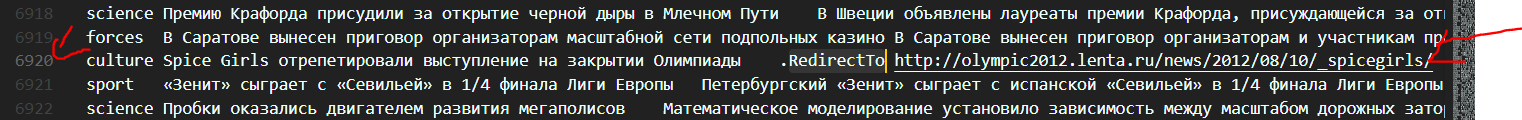

In [120]:
svc= SVC()
svc.fit(X_train_cleaned, y_train)

y_pred = svc.predict(X_test_cleaned)



accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7385


Файнтюнинг

In [41]:
history = []
K = [3, 5, 8, 12, 15, 20, 30]
for k in K:
    X_train_cleaned = [cluster_and_average_vectors(document, k=k, num=1) for document in X_train]
    # X_test_cleaned = [cluster_and_average_vectors(document, k=5, num=1) for document in X_test]
    
    svc= SVC()
    svc.fit(X_train_cleaned, y_train)
    y_pred = svc.predict(X_test_durty)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    history.append([accuracy, k])

Accuracy: 0.729
Accuracy: 0.754
Accuracy: 0.7765
Accuracy: 0.789
Accuracy: 0.7895
Accuracy: 0.7915
Accuracy: 0.7925


In [42]:
history = []
K = [3, 5, 8, 10, 12, 15, 20, 25, 30]
for k in K:
    X_train_cleaned = [cluster_and_average_vectors(document, k=k, num=1) for document in X_train]
    X_test_cleaned = [cluster_and_average_vectors(document, k=5, num=1) for document in X_test]
    
    svc= SVC()
    svc.fit(X_train_cleaned, y_train)
    y_pred = svc.predict(X_test_cleaned)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    history.append([accuracy, k])

Accuracy: 0.607
Accuracy: 0.624
Accuracy: 0.6265
Accuracy: 0.621
Accuracy: 0.609
Accuracy: 0.594
Accuracy: 0.577
Accuracy: 0.5705
Accuracy: 0.5645


In [44]:
history = []
K = [30, 35, 40, 45]
for k in K:
    X_train_cleaned = [cluster_and_average_vectors(document, k=k, num=1) for document in X_train]
    X_test_cleaned = [cluster_and_average_vectors(document, k=5, num=1) for document in X_test]
    
    svc= SVC()
    svc.fit(X_train_cleaned, y_train)
    y_pred = svc.predict(X_test_cleaned)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    history.append([accuracy, k])

Accuracy: 0.5645
Accuracy: 0.564
Accuracy: 0.565
Accuracy: 0.5585


In [45]:
history = []
K = [30, 35, 40, 45]
for k in K:
    X_train_cleaned = [cluster_and_average_vectors(document, k=k, num=1) for document in X_train]
    # X_test_cleaned = [cluster_and_average_vectors(document, k=5, num=1) for document in X_test]
    
    svc= SVC()
    svc.fit(X_train_cleaned, y_train)
    y_pred = svc.predict(X_test_durty)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    history.append([accuracy, k])

Accuracy: 0.7895
Accuracy: 0.788
Accuracy: 0.7935
Accuracy: 0.7945


In [47]:
history = []
K = [45, 50 ,55, 60, 80, 100]
for k in K:
    X_train_cleaned = [cluster_and_average_vectors(document, k=k, num=2) for document in X_train]
    # X_test_cleaned = [cluster_and_average_vectors(document, k=5, num=1) for document in X_test]
    
    svc= SVC()
    svc.fit(X_train_cleaned, y_train)
    y_pred = svc.predict(X_test_durty)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    history.append([accuracy, k])

Accuracy: 0.7945
Accuracy: 0.7955
Accuracy: 0.7955
Accuracy: 0.798
Accuracy: 0.798
Accuracy: 0.796


Видимо, уже и так хорошо отчистил документы от мусора и если что-то убираю, становится только хуже